In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image


Reduced Images:


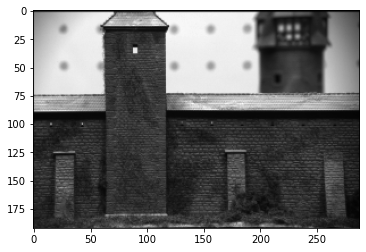

(192, 288)
----------------------------------


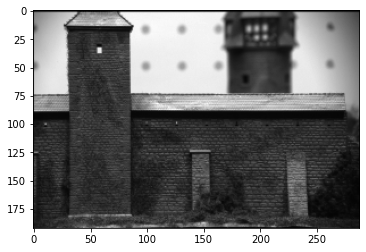

(192, 288)
----------------------------------


In [2]:
# i. Read in two images and resize them to 50% of their original size.

#use_cast = True
cast_path = "./image/cast"
cones_path = "./image/cones"
use_cast = True
if use_cast:
    path = cast_path
else:
    path = cones_path


files = [filename for filename in sorted(os.listdir(
    path)) if os.path.isfile(os.path.join(path, filename))]

colors = []
grays = []
for i in range(0, len(files)):
    img = cv2.imread(os.path.join(path, files[i]))
    colors.append(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # gray_img = cv2.GaussianBlur(gray_img, (11, 11), cv2.BORDER_DEFAULT)
    grays.append(gray_img)

scale = 0.5
img1 = cv2.resize(grays[0], None, fx=scale, fy=scale,
                  interpolation=cv2.INTER_LINEAR)
img2 = cv2.resize(grays[1], None, fx=scale, fy=scale,
                  interpolation=cv2.INTER_LINEAR)

print('Reduced Images:')

plt.imshow(img1, cmap='gray')
plt.show()
print(img1.shape)
print('----------------------------------')
plt.imshow(img2, cmap='gray')
plt.show()
print(img2.shape)
print('----------------------------------')


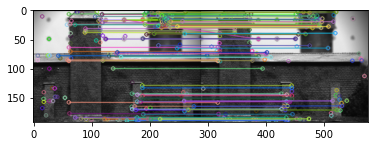

----------------------------------
length of pts1:  113
length of pts2:  113
----------------------------------


In [3]:
# 1. Find interesting features and correspondences between the left and right
# images. You can use the CORNERS and NCC algorithms that you wrote/used for
# the second project or SIFT features and descriptors. Display your results in
# the same way you did for project 2 i.e. by connecting corresponding features
# with a line. Using lines of different colors for different points makes it
# easier to visualize the results.

# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html


# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# # FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=500)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)


# Need to draw only good matches, so create a mask
matchesMask = [[0, 0] for i in range(len(matches))]

good_matches = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i] = [1, 0]
        good_matches.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None,
                          matchesMask=matchesMask, flags=0)

plt.imshow(img3,)
plt.show()

print('----------------------------------')
print('length of pts1: ', len(pts1))
print('length of pts2: ', len(pts2))
print('----------------------------------')


original points (113, 2) (113, 2)
[[ 2.26778487e-20  2.69542430e-18 -8.67381958e-18]
 [-2.74327207e-18  3.93747263e-20 -8.63857570e-03]
 [ 9.38285805e-19  8.63857570e-03  7.77156117e-16]]
----------------------------------
inliers points (109, 2) (109, 2)


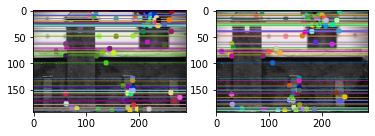

In [4]:
# 2. Write a program to estimate the Fundamental Matrix for each pair using the
# correspondences above and RANSAC to eliminate outliers. Display the inlier
# correspondences in the same way as above.


def drawlines(image1, image2, lines, pts1, pts2):
    r, c = image1.shape
    image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        image1 = cv2.line(image1, (x0, y0), (x1, y1), color, 1)
        image1 = cv2.circle(image1, tuple(pt1), 5, color, -1)
        image2 = cv2.circle(image2, tuple(pt2), 5, color, -1)

    return image1, image2


def normalize_points(pts):
    mean = np.mean(pts, axis=0)
    std_dev = np.std(pts)
    scale = np.sqrt(2) / std_dev
    T = np.array([[scale, 0, -scale * mean[0]],
                  [0, scale, -scale * mean[1]],
                  [0, 0, 1]])
    normalized_pts = np.dot(T, np.column_stack(
        (pts, np.ones(pts.shape[0]))).T).T[:, :2]
    return normalized_pts, T


def compute_fundamental(pts1, pts2):
    assert len(pts1) == len(pts2) and len(pts1) >= 8

    A = np.zeros((len(pts1), 9))
    for i, (pt1, pt2) in enumerate(zip(pts1, pts2)):
        A[i] = [pt1[0] * pt2[0], pt1[0] * pt2[1], pt1[0],
                pt1[1] * pt2[0], pt1[1] * pt2[1], pt1[1],
                pt2[0], pt2[1], 1]
    A.astype(np.float64)
    _, _, V = np.linalg.svd(A)
    F = V.T[:, -1].reshape(3, 3)

    # Enforce the rank 2 constraint
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    # vh = V.T

    # last_col = vh[:, vh.shape[1] - 1]  # last col of v

    # if len(last_col) != 9:
    #     raise ValueError("last col is not of right size :/ %s " %
    #                      len(last_col))

    # F = np.asarray([[last_col[0], last_col[3], last_col[6]],
    #                 [last_col[1], last_col[4], last_col[7]],
    #                 [last_col[2], last_col[5], last_col[8]]])

    # u, s, vh = np.linalg.svd(F, full_matrices=True)
    # s[s.shape[0] - 1] = 0
    # F_reconstructed = np.matmul(np.matmul(u, np.diag(s)), vh)

    # Denormalize the fundamental matrix
    # F = np.dot(T2.T, np.dot(F, T1))

    return F


def compute_error(F, pt1, pt2):
    pt1_h = np.append(pt1, 1).astype(np.float64)
    pt2_h = np.append(pt2, 1).astype(np.float64)
    line = np.dot(F, pt1_h)
    error = np.abs(np.dot(pt2_h, line)) / np.sqrt(line[0] ** 2 + line[1] ** 2)
    return error


def RANSAC(pts1, pts2, threshold=3, iterations=2000):
    assert len(pts1) == len(pts2) and len(pts1) >= 8

    best_inliers = []
    best_F = None

    for _ in range(iterations):
        sample_indices = np.random.choice(len(pts1), 8, replace=False)
        sample_pts1 = pts1[sample_indices]
        sample_pts2 = pts2[sample_indices]

        F = compute_fundamental(sample_pts1, sample_pts2)

        inliers = []
        for i, (pt1, pt2) in enumerate(zip(pts1, pts2)):
            error = compute_error(F, pt1, pt2)
            if error < threshold:
                inliers.append(i)

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_F = F

    return best_F, best_inliers


pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

print('original points', pts1.shape, pts2.shape)

# Find the fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1)
# print(F)
# print(mask.ravel().sum(), 'inliers')
# F, inliers = RANSAC(pts1, pts2, threshold=1, iterations=5000)
print(F)

print('----------------------------------')

# We select only inlier points
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]
# pts1_inliers = pts1[inliers]
# pts2_inliers = pts2[inliers]
print('inliers points', pts1_inliers.shape, pts2_inliers.shape)

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2_inliers.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1_inliers, pts2_inliers)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1_inliers.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2_inliers, pts1_inliers)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()


In [5]:
def ncc_patch(window1, window2):
    aux1 = window1 / np.linalg.norm(window1)
    aux2 = window2 / np.linalg.norm(window2)
    ncc = float(np.sum(aux1 * aux2))
    return ncc


def generate_disparity_color_map(vertical_disp, horizontal_disp, disparity_range):
    h, w = vertical_disp.shape
    disp_color = np.zeros((h, w, 3), dtype=np.uint8)
    disp_color[..., 0] = np.arctan2(
        vertical_disp, horizontal_disp) * 180 / np.pi % 180
    disp_color[..., 1] = np.sqrt(
        horizontal_disp ** 2 + vertical_disp ** 2) * (255 / np.sqrt(2 * disparity_range ** 2))
    disp_color[..., 2] = 255
    disp_color = cv2.cvtColor(disp_color, cv2.COLOR_HSV2BGR)

    return disp_color


def find_best_patch(window1, start, end, image2, epipolar_line, window_size):
    hw = window_size // 2
    best_match = (-100, (-1, -1))
    for x2 in range(start, end):

        y2 = int(
            (-epipolar_line[2] - (x2 * epipolar_line[0])) / epipolar_line[1])

        if y2-hw >= 0 and y2+hw < image2.shape[0]:
            window2 = image2[y2 - hw:y2 + hw + 1, x2 - hw:x2 + hw + 1]
            ncc = ncc_patch(window1, window2)
            if ncc > best_match[0]:
                best_match = (ncc, (y2, x2))

    return best_match


# compute the disparity map through the epipolar line from the foundamental matrix F to reduce the search space
def compute_dense_disparity_map_fast(image1, image2, F, window_size=5, disparity_range=70):
    print(F)
    hw = window_size // 2
    h, w = image1.shape
    vertical_disp = np.zeros_like(image1, dtype=np.float32)
    horizontal_disp = np.zeros_like(image1, dtype=np.float32)
    invalid = np.zeros_like(image1, dtype=np.uint8)
    sc = np.zeros_like(image1, dtype=np.float32)

    for y1 in range(hw, h - hw - 1):
        prior_disp = None
        for x1 in range(hw, w - hw - 1):
            window1 = image1[y1 - hw:y1 + hw + 1, x1 - hw:x1 + hw + 1]
            point1 = np.array([x1, y1, 1])
            epipolar_line = np.dot(F, point1)
            epipolar_line = epipolar_line / np.linalg.norm(epipolar_line)

            start = max(x1 - disparity_range, hw)
            end = min(x1 + disparity_range, w - hw)
            # if prior_disp is None:
            score, (best_y2, best_x2) = find_best_patch(
                window1, start, end, image2, epipolar_line, window_size)

            horizontal_disp[y1, x1] = x1 - best_x2
            vertical_disp[y1, x1] = y1 - best_y2
            sc[y1, x1] = score

    return horizontal_disp, vertical_disp, sc

# compute horizontal and vertical disparity map and score map
horizontal_disp, vertical_disp, sc = compute_dense_disparity_map_fast(img1, img2, F)

[[ 2.26778487e-20  2.69542430e-18 -8.67381958e-18]
 [-2.74327207e-18  3.93747263e-20 -8.63857570e-03]
 [ 9.38285805e-19  8.63857570e-03  7.77156117e-16]]


In [6]:
def disparity_to_hsv(horizontal_disp, vertical_disp):
    h, w = horizontal_disp.shape
    difference = horizontal_disp - vertical_disp

    # Calculate magnitude and angle of the disparity vectors
    magnitude = np.sqrt(horizontal_disp**2 + vertical_disp**2)
    angle = np.arctan2(vertical_disp, horizontal_disp) * 180 / np.pi

    # Normalize the magnitude to the range [0, 1]
    magnitude_normalized = cv2.normalize(
        magnitude, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # Convert angle to hue in the range [0, 180]
    hue = angle.copy() 
    hue[difference < 0] = 360 - angle[difference < 0]
    print(np.min(hue), np.max(hue))

    # Create the HSV image
    hsv = np.zeros((h, w, 3), dtype=np.float32)
    hsv[..., 0] = hue
    hsv[..., 1] = magnitude_normalized
    hsv[..., 2] = 1  # Set the value channel to maximum

    return hsv


disparity_color = disparity_to_hsv(horizontal_disp, vertical_disp)

0.0 180.00002


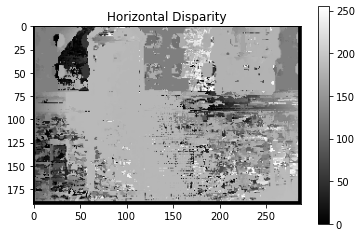

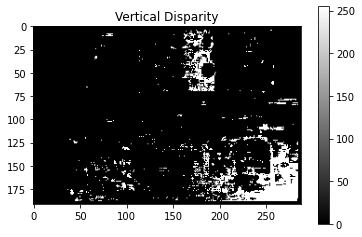

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


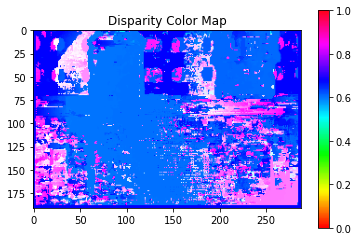

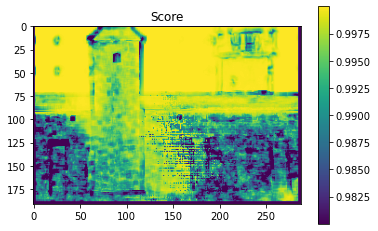

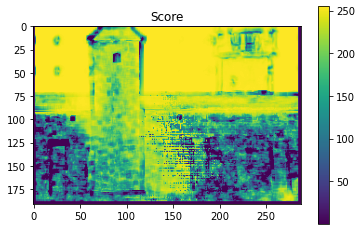

In [7]:
def normalize(disp):
    norm_disp = np.zeros_like(disp)
    norm_disp = cv2.normalize(
        disp, norm_disp, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return norm_disp
norm_horizontal_disp = normalize(horizontal_disp)
norm_vertical_disp = normalize(vertical_disp)

norm_horizontal_disp = norm_horizontal_disp*sc
plt.title("Horizontal Disparity")
plt.imshow(norm_horizontal_disp, cmap='gray')
plt.colorbar()
plt.show()

# Display the vertical disparity image
plt.title("Vertical Disparity")
plt.imshow(norm_vertical_disp, cmap='gray')
plt.colorbar()
plt.show()

# Display the disparity color map
# for d in disparity_color:
#     print(d)
plt.title("Disparity Color Map")
plt.imshow(disparity_color, cmap='hsv')
plt.colorbar()
plt.show()

sc[sc < 0.98] = 0.98
plt.title("Score")
plt.imshow(sc)
plt.colorbar()
plt.show()

normalized_image = np.zeros_like(sc)
cv2.normalize(sc, normalized_image, alpha=0, beta=255,
              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.title("Score")
plt.imshow(normalized_image)
plt.colorbar()
plt.show()
